# Mode choice models: vendors combined RPLM 

Random parameter logit model

Test a model that uses results from v0,v1,v2,v3

Note v1 has different attribute levels. 
How to handle all vendors at once?

Idea 1:
- No time parameter; just cost and privacy
- limit choices dataset to where time is the same for both modes (drone and ground vehicle) in each choice

1a:

- Only include choices where time = 30mins (1/16 data points)
- 30mins is a shared attribute level across all vendor types

Use a random coefficient model for cost.

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,g_cost,d_cost,g_time,d_time,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,0,0,20,15,0,1,1,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,3,0,20,20,0,0,1,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,0,3,45,20,0,1,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,10,0,30,360,0,0,1,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,5,0,45,45,0,0,1,0,-5,0


In [3]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

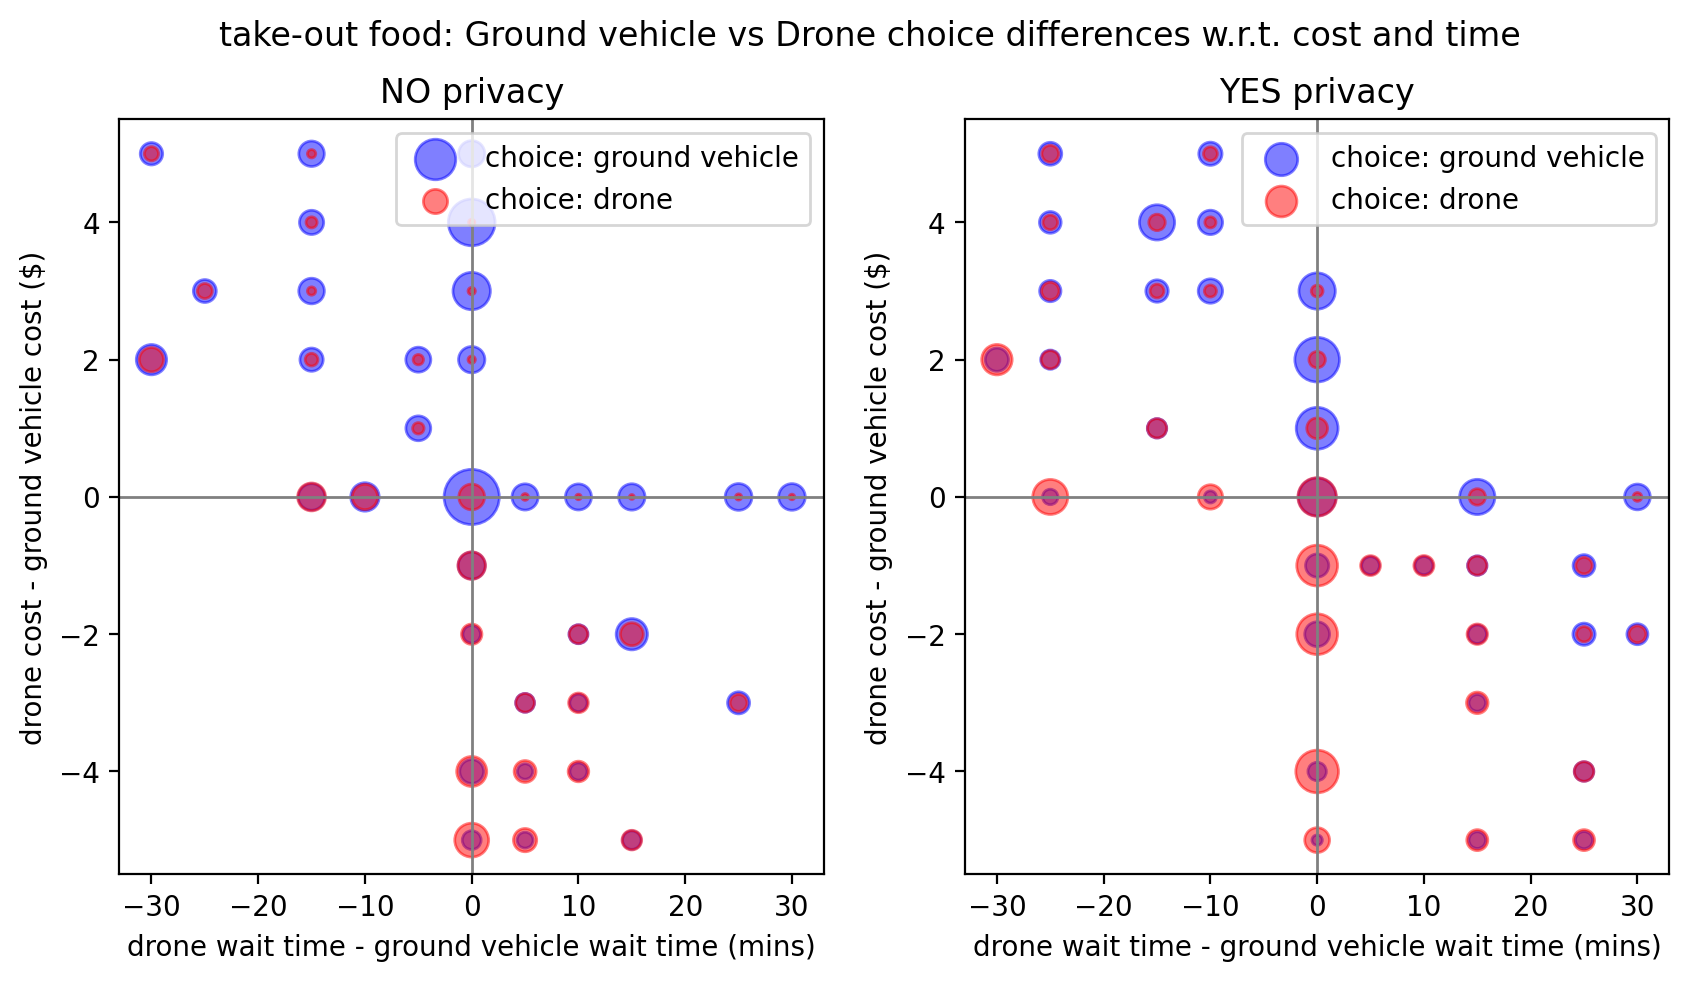

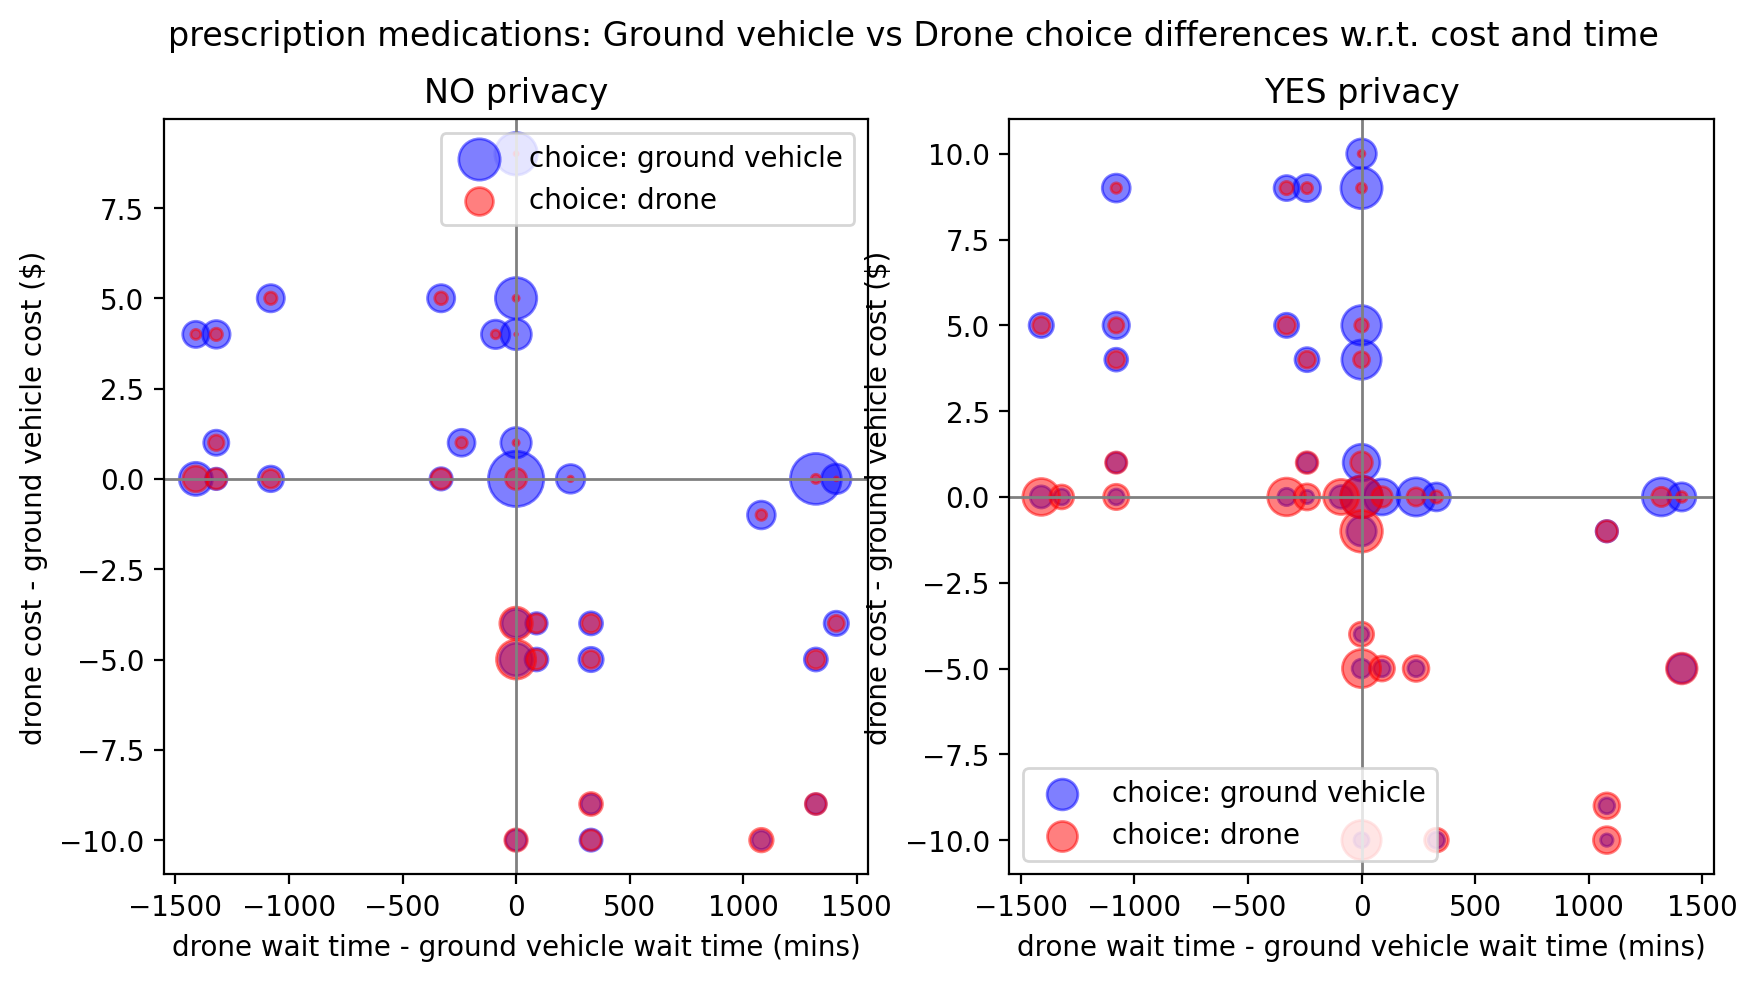

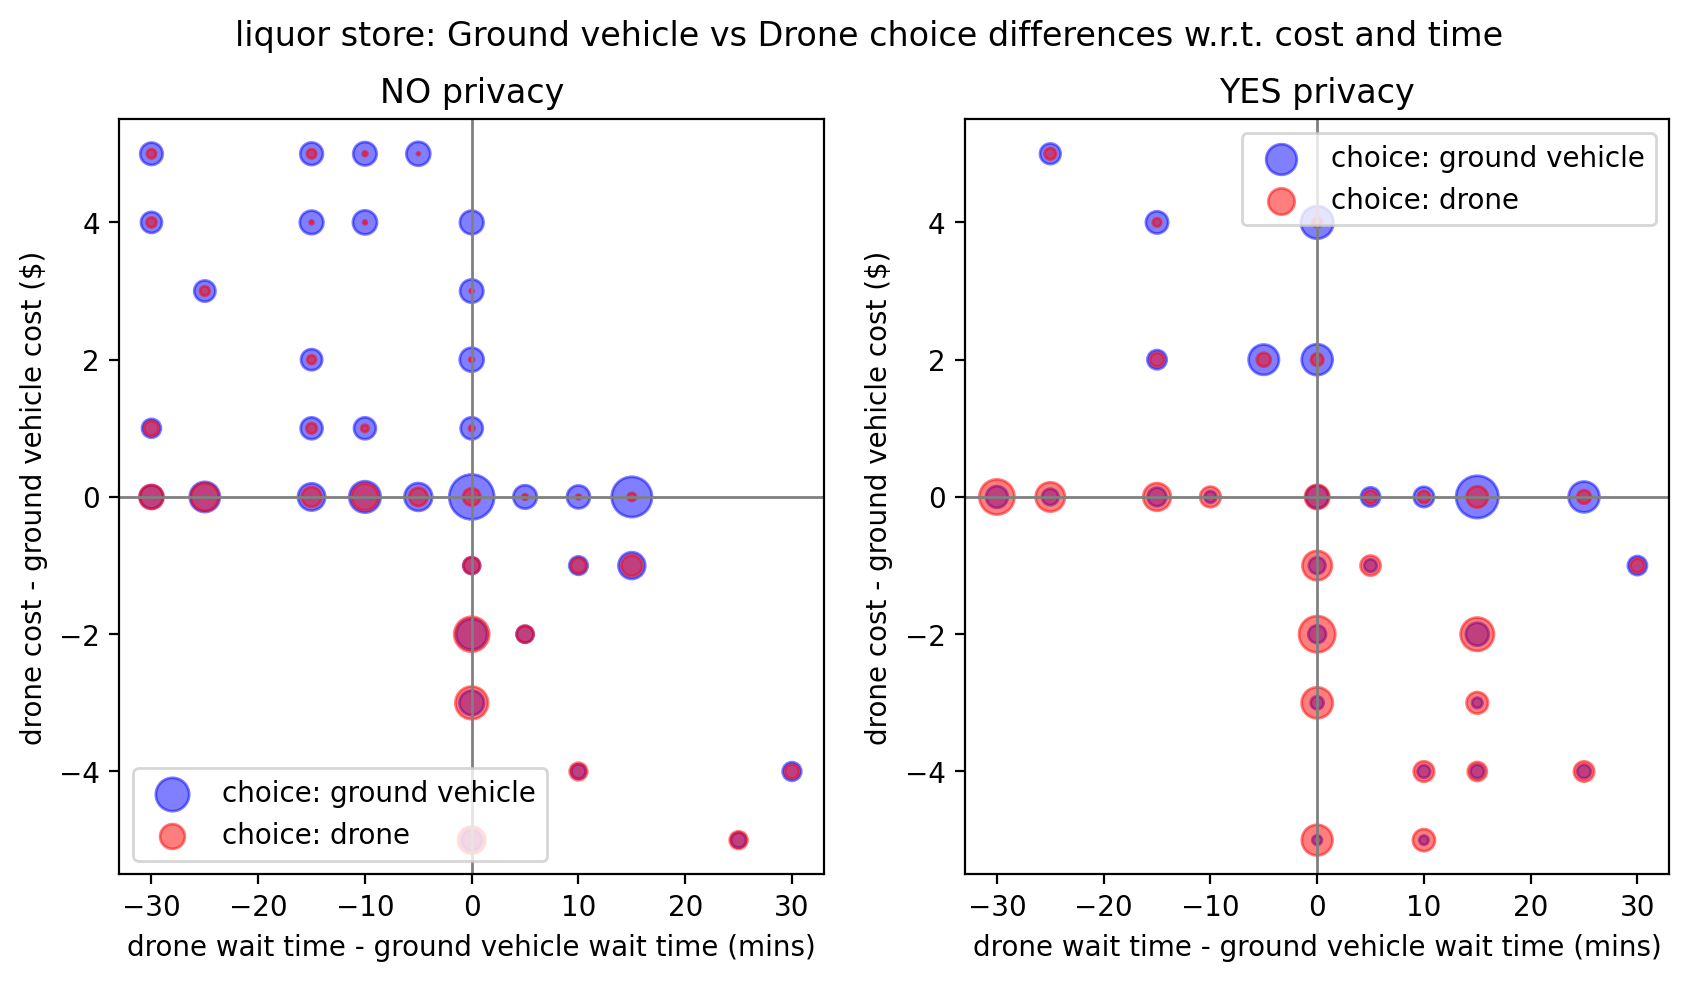

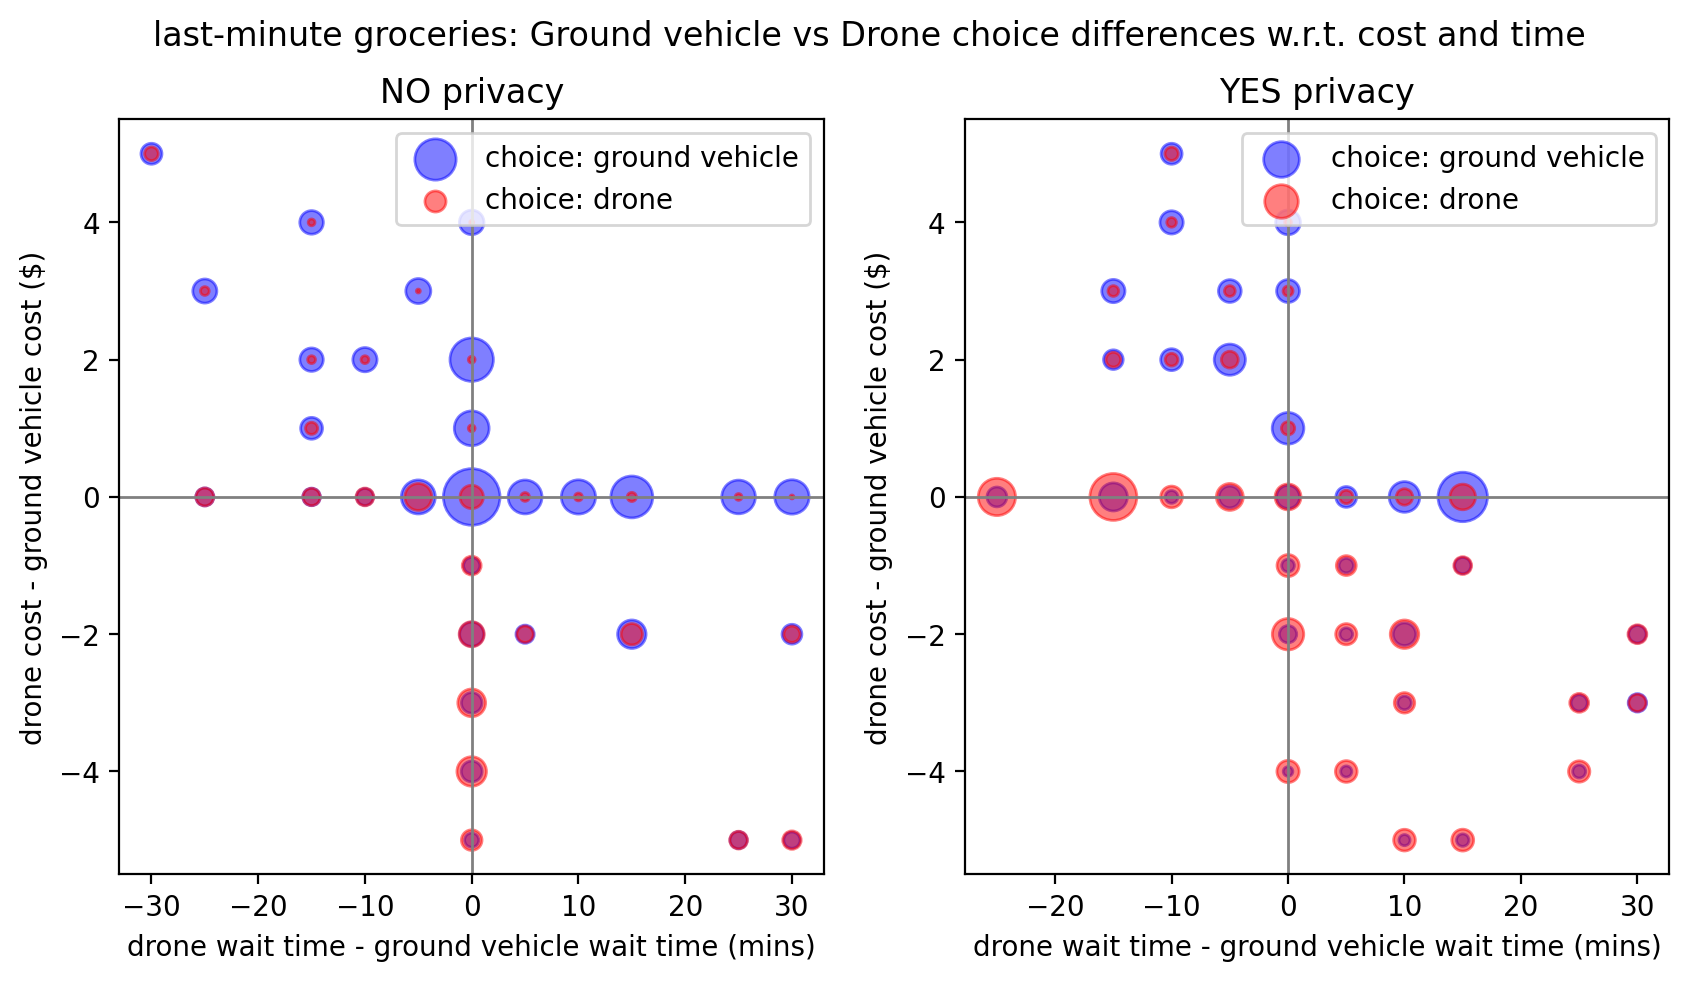

In [4]:
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_df[choices_df['v']==v]
    plot_points_tradeoff_by_size(vdf, vendor_type[0])

#### Add a dummy variable for each vendor type

In [5]:
choices_df['takeout_food'] = choices_df['v'].apply(lambda v: 1 if v==0 else 0)
choices_df['medications'] = choices_df['v'].apply(lambda v: 1 if v==1 else 0)
choices_df['liquor_store'] = choices_df['v'].apply(lambda v: 1 if v==2 else 0)
choices_df['groceries'] = choices_df['v'].apply(lambda v: 1 if v==3 else 0)

Make a choice set limited to choices where time is the same across mode types.

This takes time out of the equation.

In [6]:
choices_no_t_df = choices_df[(choices_df['g_time']==choices_df['d_time'])]
print('%0.2f = %s/%s choices with drone time = ground vehicle time' % (
    len(choices_no_t_df)/len(choices_df), len(choices_no_t_df), len(choices_df)))
choices_no_t_df.head()

0.36 = 12995/36297 choices with drone time = ground vehicle time


,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID,takeout_food,medications,liquor_store,groceries
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,0,0,1,0,-3,0,0,0,1,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,0,0,1,0,-5,0,0,0,1,0
5,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc0_gt0_dc1_dt0_dp1_1.1,0,1,0,0,1,0,1,1,...,1,1,0,0,1,0,0,1,0,0
9,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc1_gt1_dc0_dt1_dp0_1.1,1,0,1,1,0,1,0,1,...,0,0,1,0,-1,0,1,0,0,0
10,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc3_gt0_dc1_dt0_dp0_1.1,1,0,3,0,1,0,0,1,...,0,0,0,0,-4,0,1,0,0,0


Try limiting to just time = 30mins

In [7]:
choices_t30_df = choices_df[(choices_df['g_time']==30) & (choices_df['d_time']==30)]
print('%s/%s choices with time = 30 mins across all vendors and mode types' % (
    len(choices_t30_df), len(choices_df)))
choices_t30_df.head()

3266/36297 choices with time = 30 mins across all vendors and mode types


,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID,takeout_food,medications,liquor_store,groceries
5,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc0_gt0_dc1_dt0_dp1_1.1,0,1,0,0,1,0,1,1,...,1,1,0,0,1,0,0,1,0,0
33,R_1MR2SvVMCux6Cwe,CHOICE_v2_gc3_gt2_dc2_dt2_dp1_1.1,0,2,3,2,2,2,1,1,...,1,0,0,0,-2,3,0,0,1,0
37,R_1MR2SvVMCux6Cwe,CHOICE_v3_gc2_gt2_dc0_dt2_dp0_1.1,0,3,2,2,0,2,0,1,...,0,0,1,0,-3,3,0,0,0,1
43,R_1MR2SvVMCux6Cwe,CHOICE_v0_gc0_gt2_dc1_dt2_dp1_1.1,0,0,0,2,1,2,1,1,...,1,1,0,0,1,3,1,0,0,0
53,R_2sSZQeFyNBEsUjH,CHOICE_v0_gc1_gt2_dc3_dt2_dp0_1.1,0,0,1,2,3,2,0,0,...,0,0,0,0,4,4,1,0,0,0


In [8]:
len(choices_t30_df[choices_t30_df['v']==1])

922

In [9]:
def plot_points_cost(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_cost','g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_cost','g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_cost'],
            df_p_agg['g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_cost'],
            df_p_agg['g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('(\$) drone cost')
        ax.set_ylabel('(\$) ground vehicle cost')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice choices; comparing cost' % vendor)
    _ = fig.suptitle(title)

limited to choices where drone time = ground vehicle time


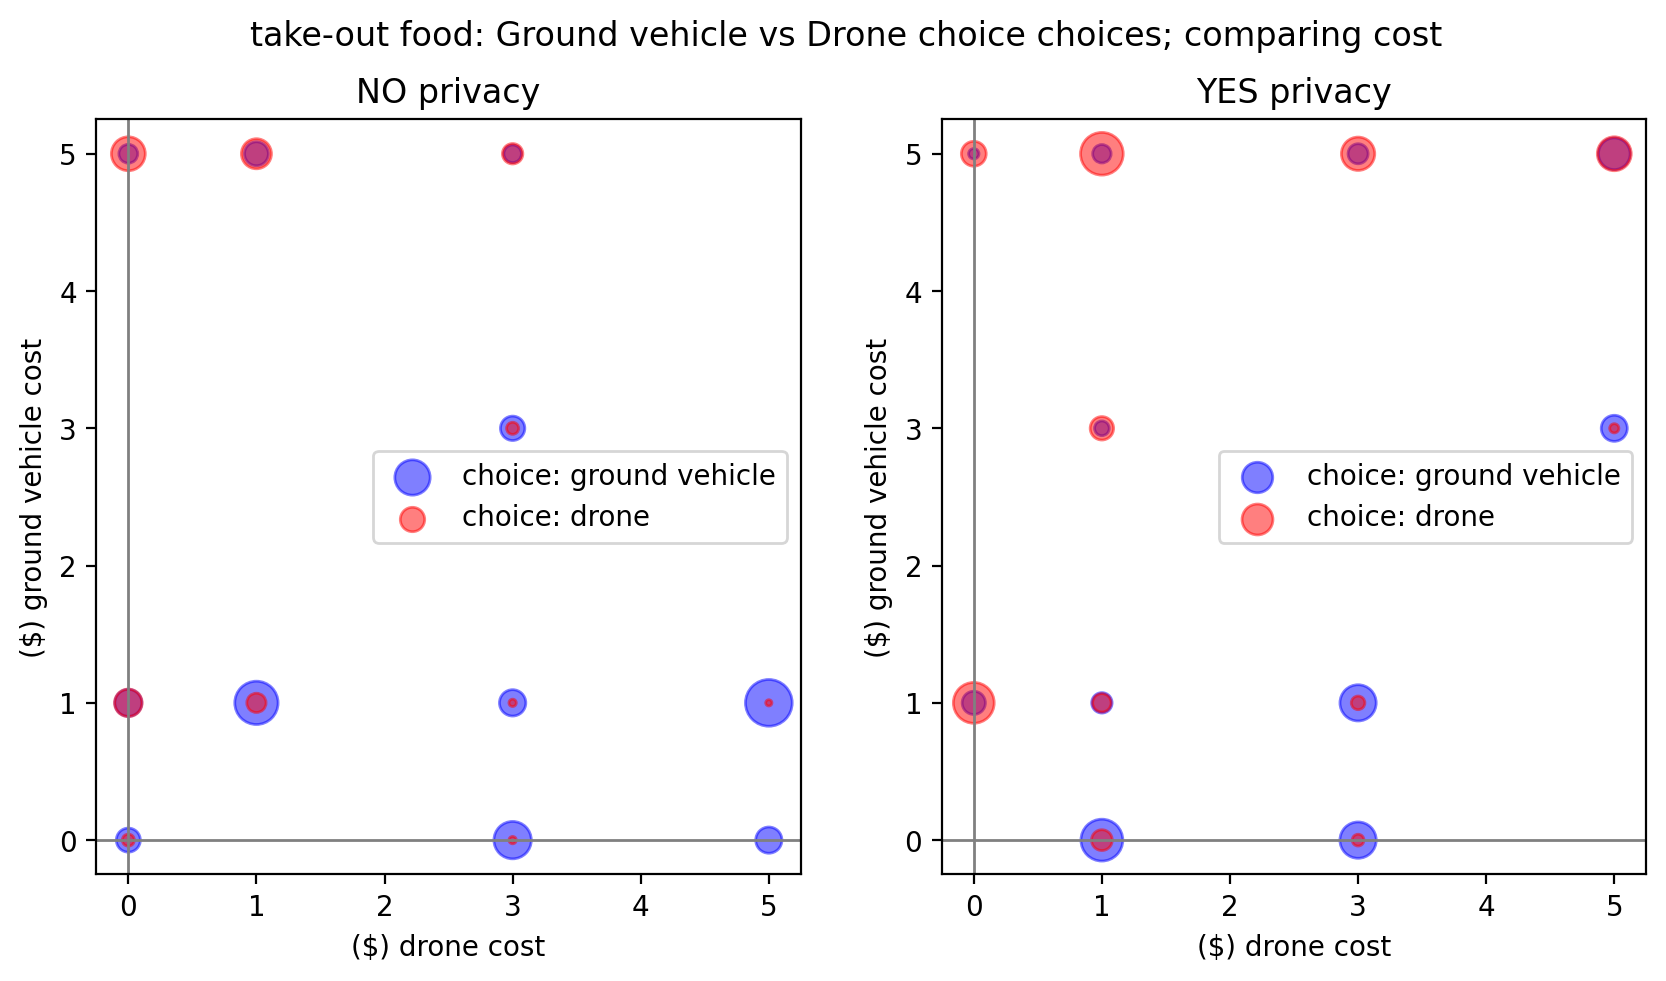

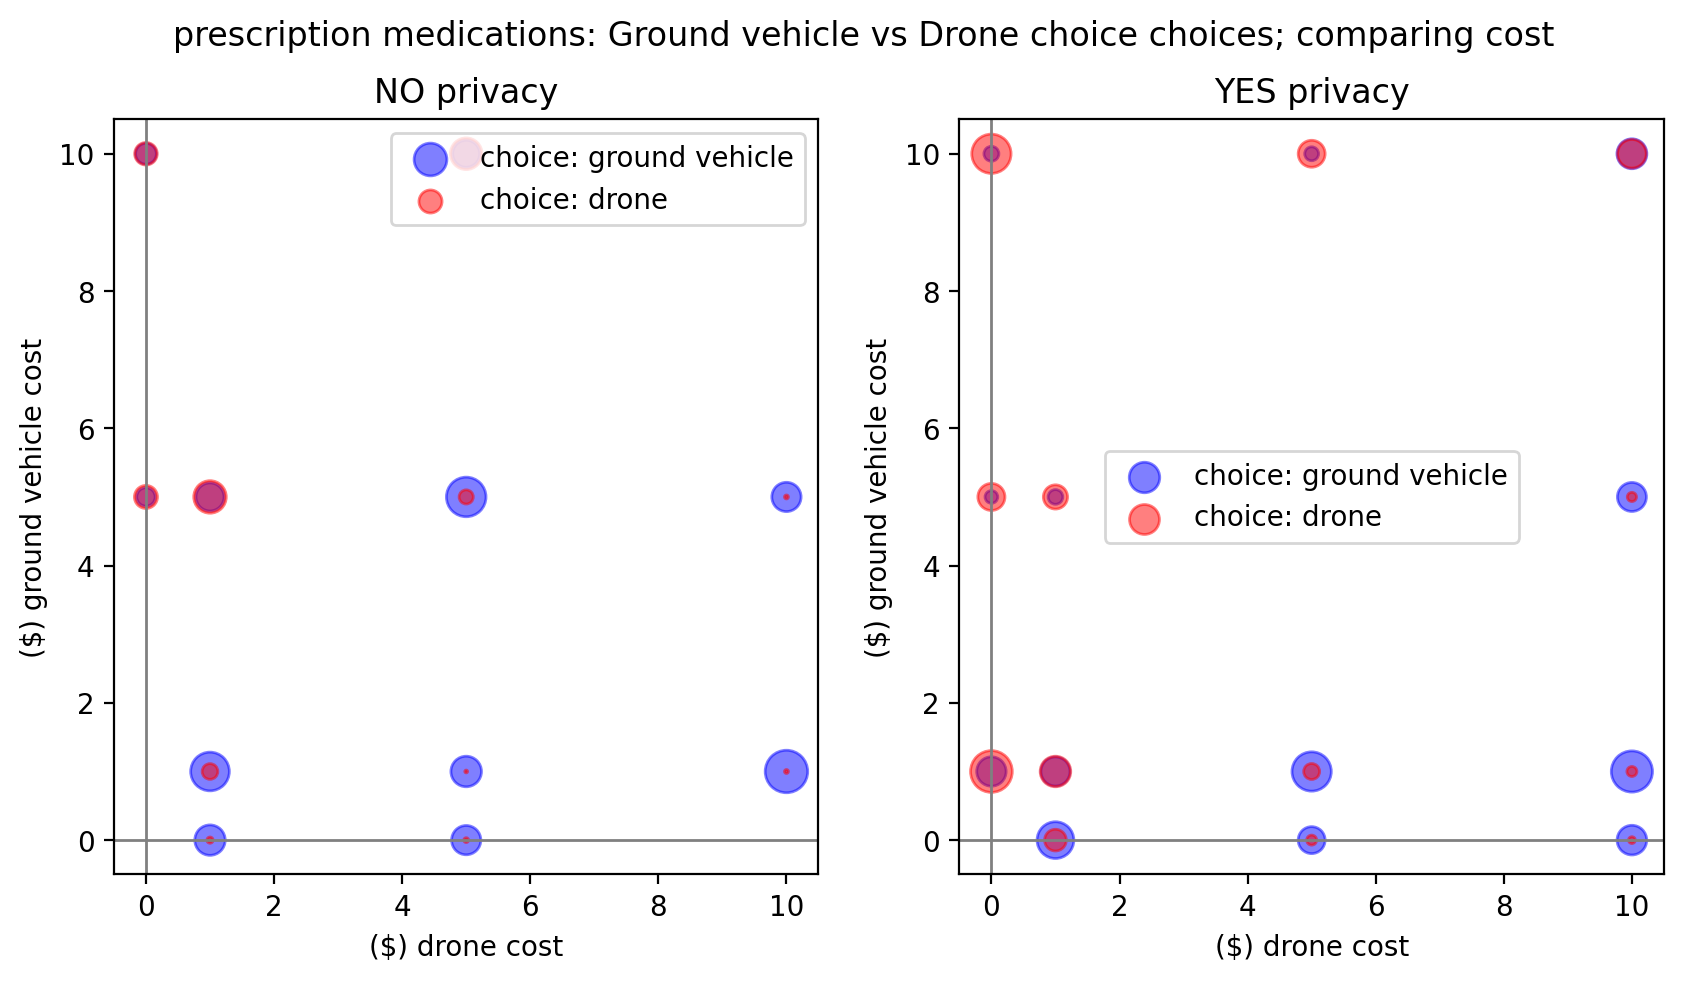

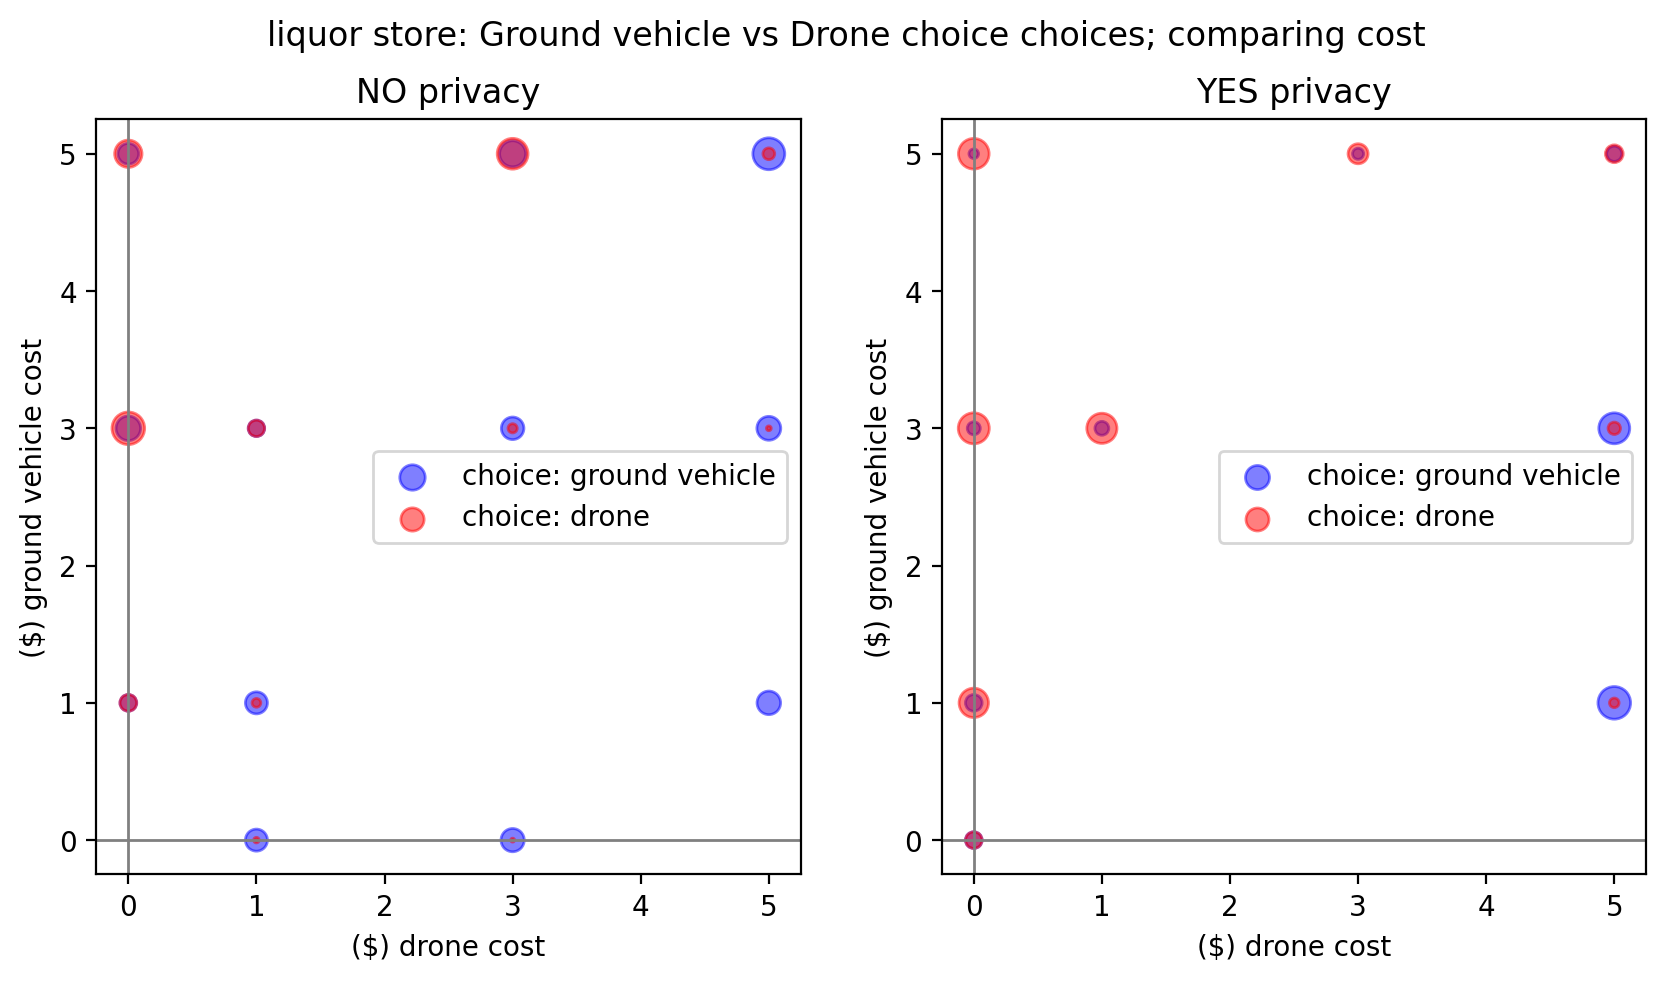

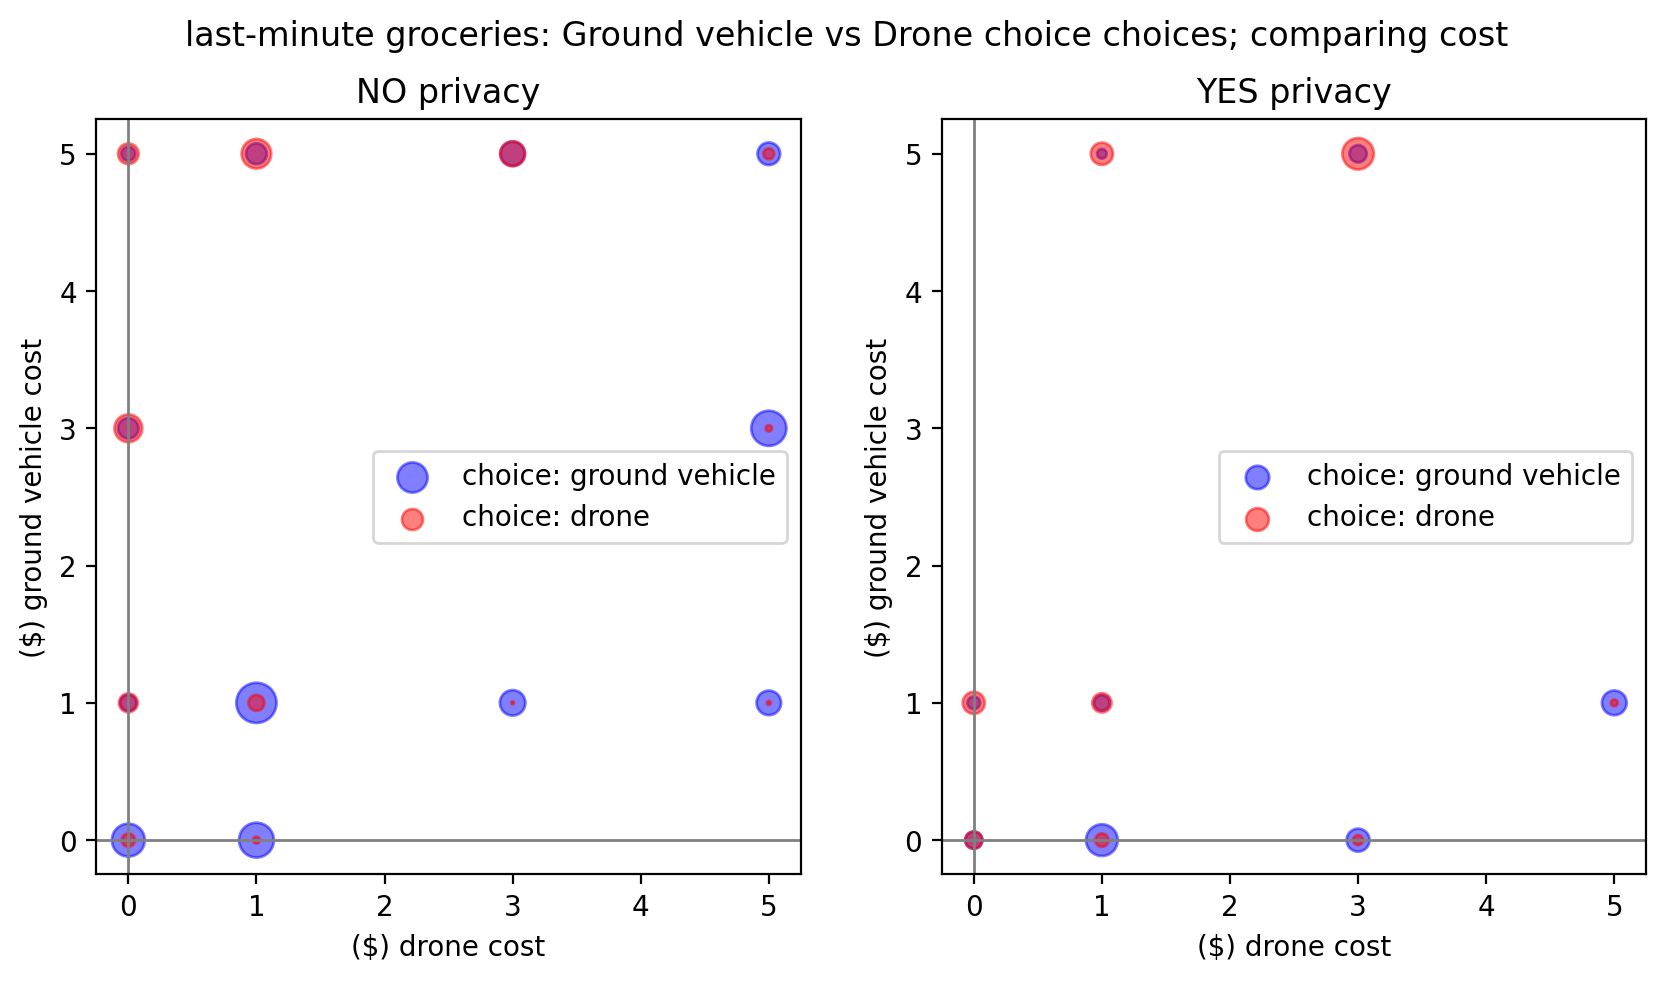

In [10]:
print('limited to choices where drone time = ground vehicle time')
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_no_t_df[choices_no_t_df['v']==v]
    plot_points_cost(vdf, vendor_type[0])

limited to choices where drone time = ground vehicle time = 30mins


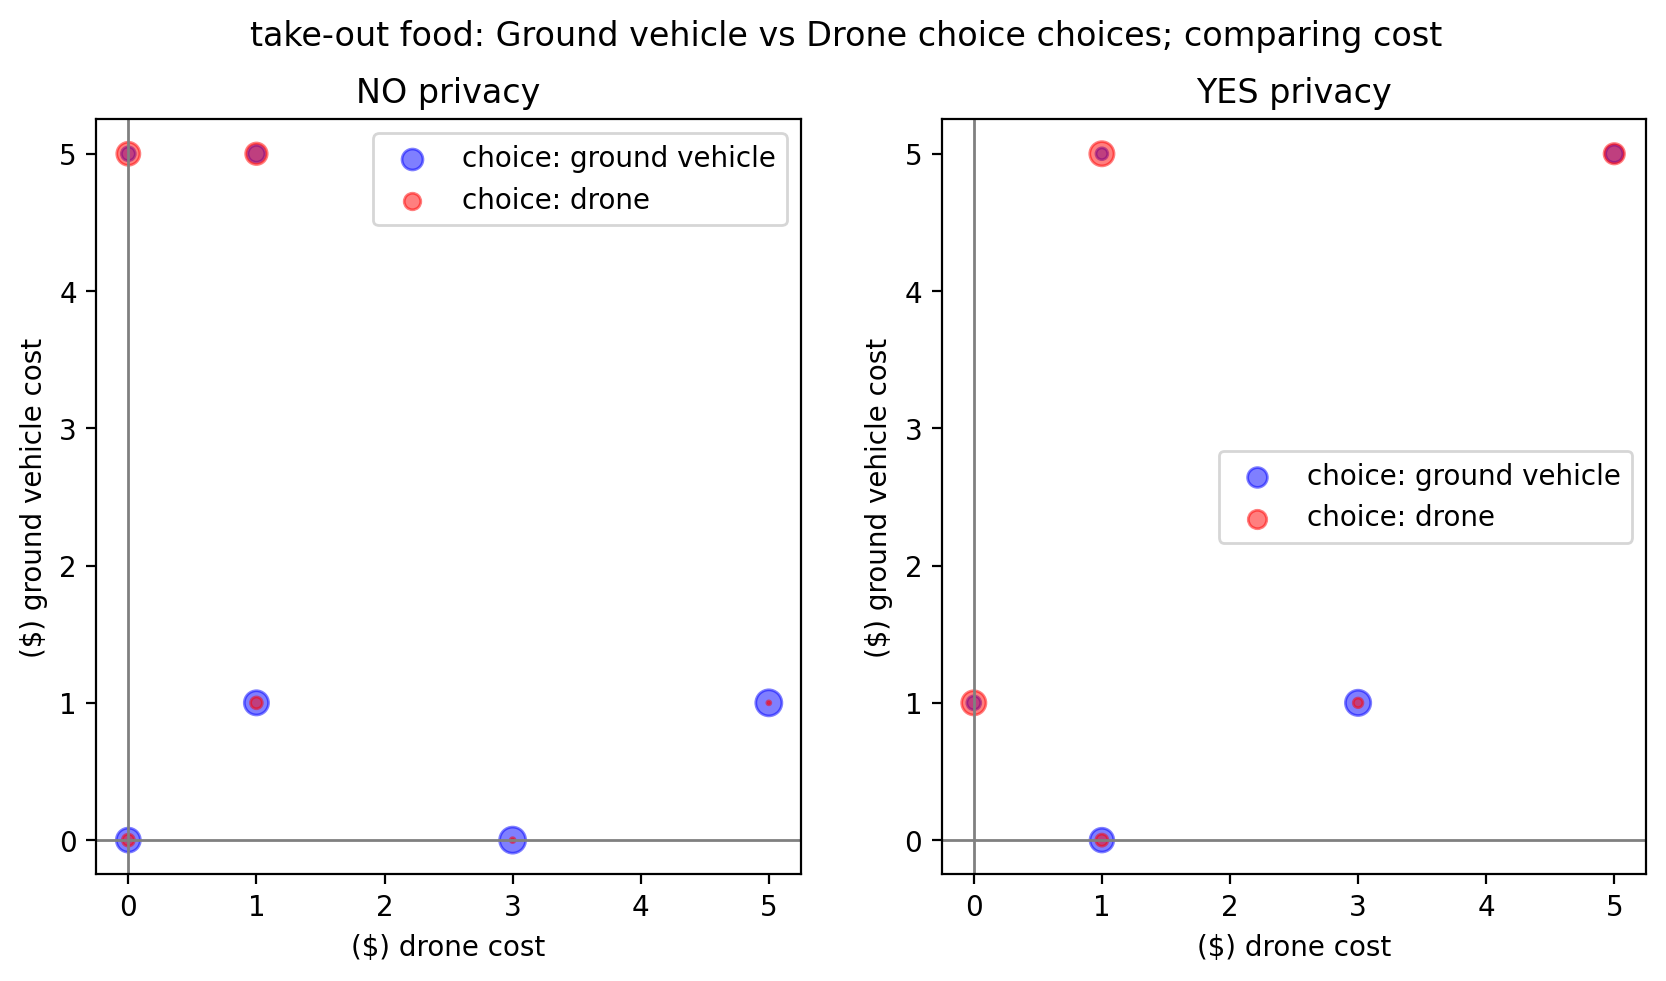

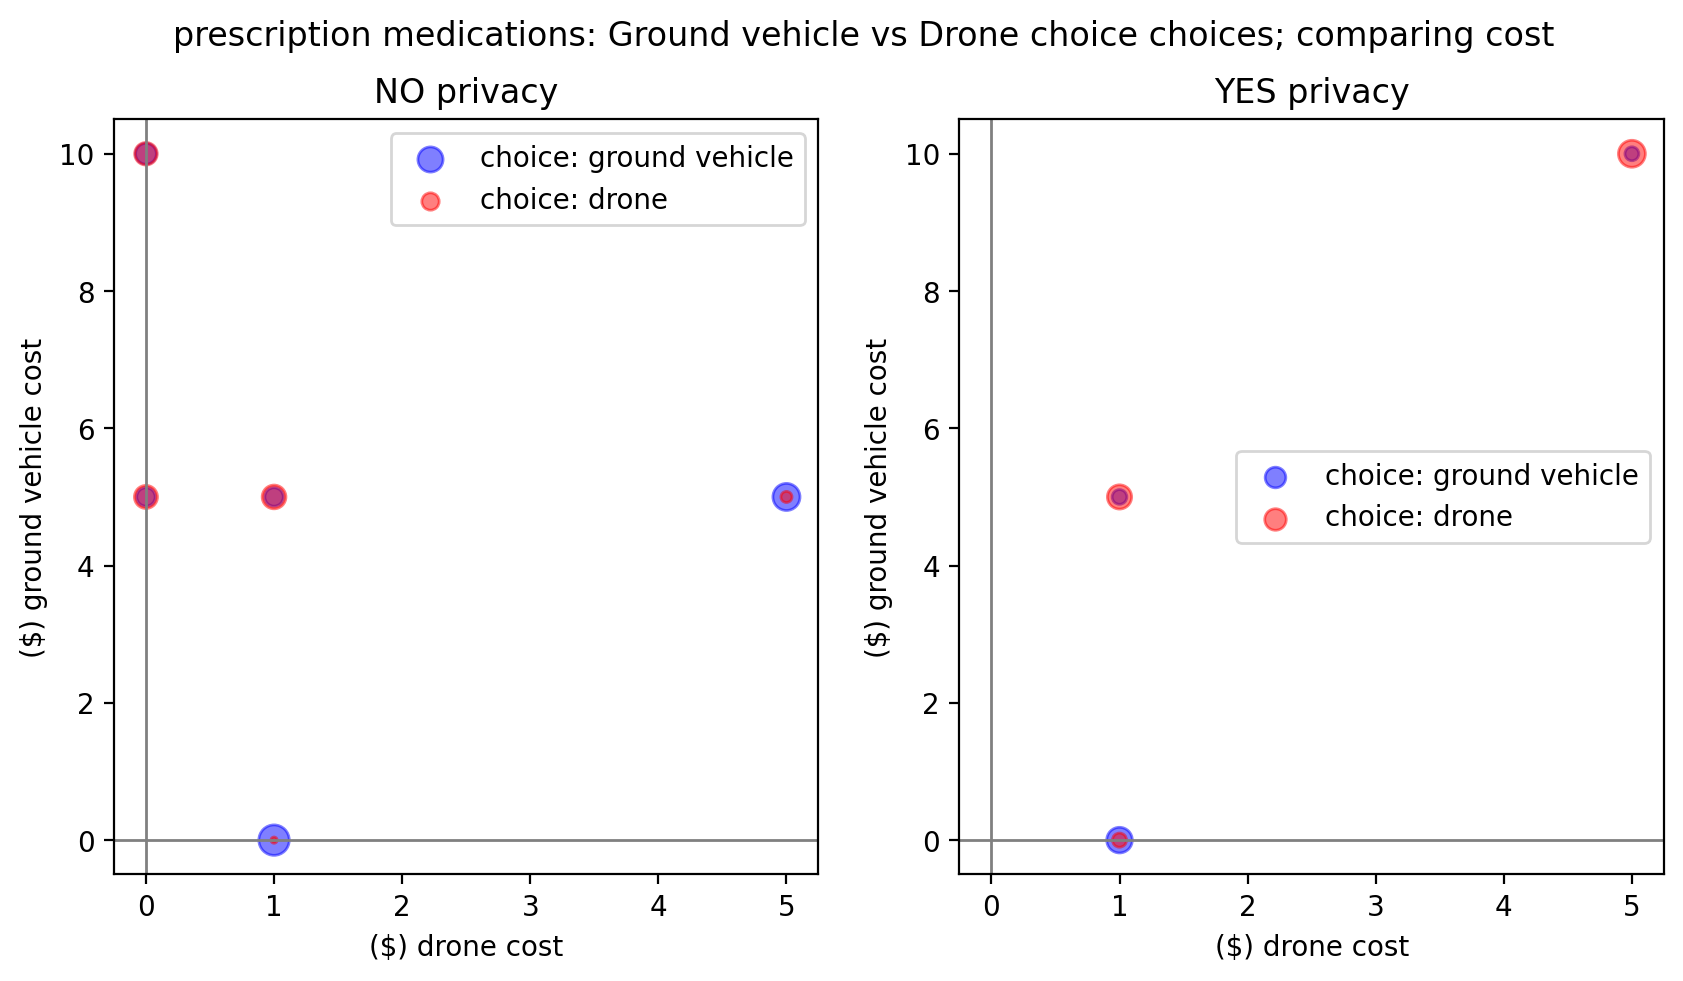

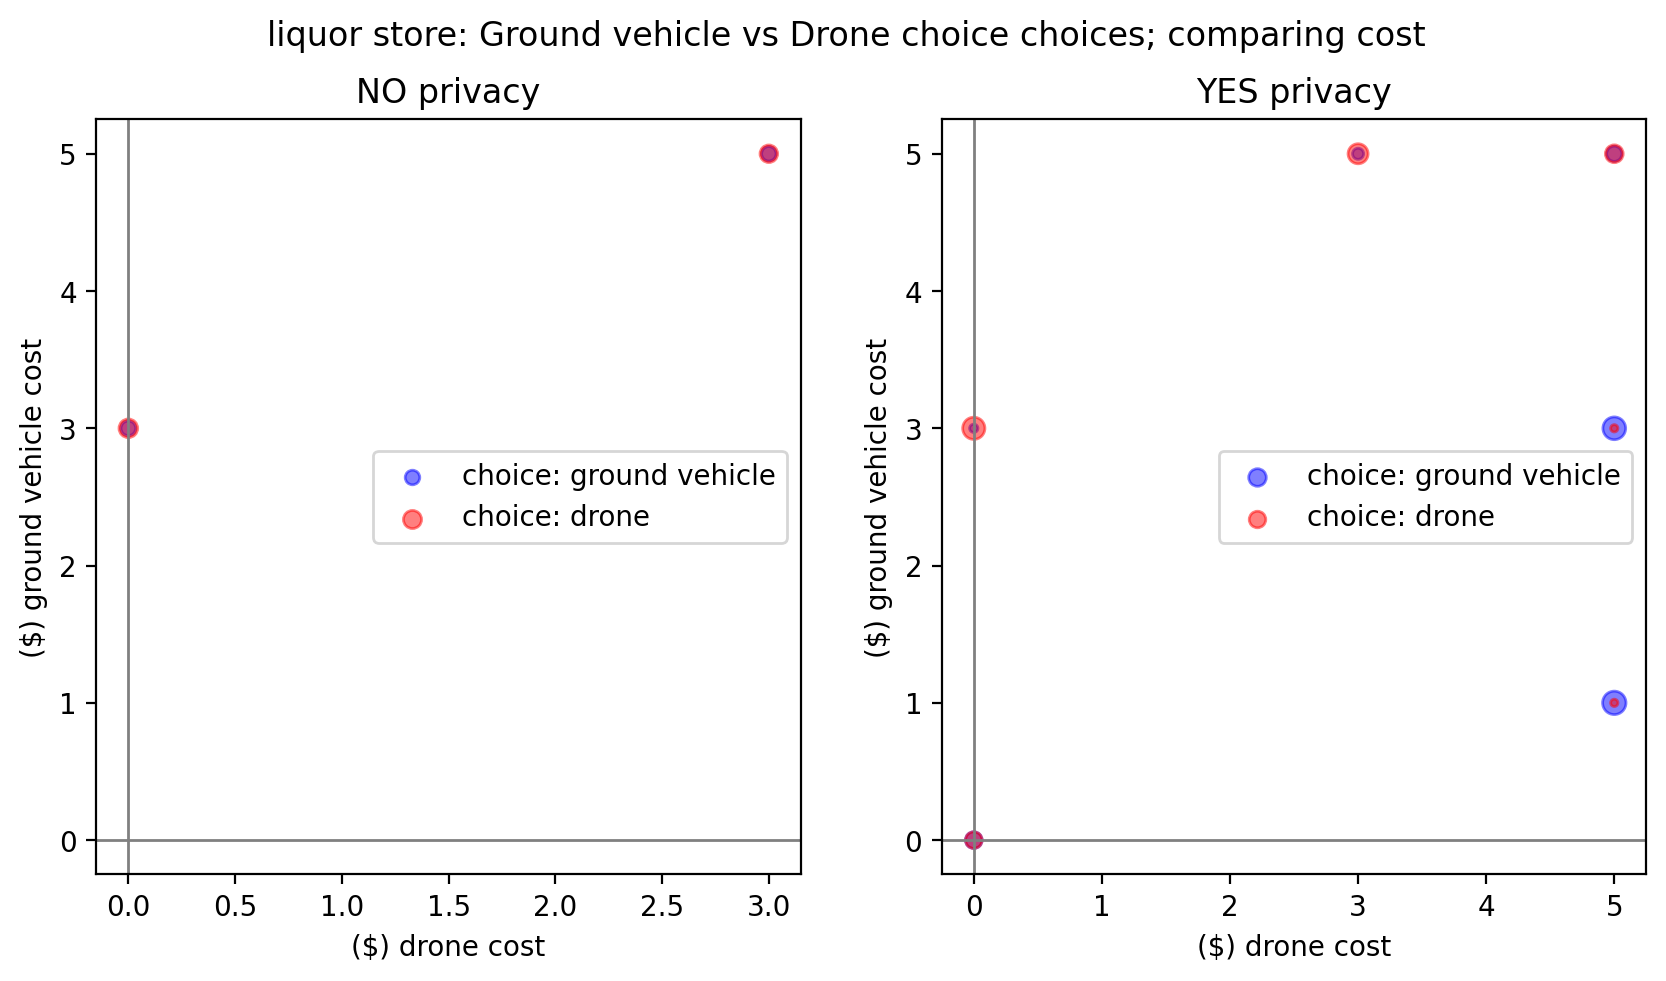

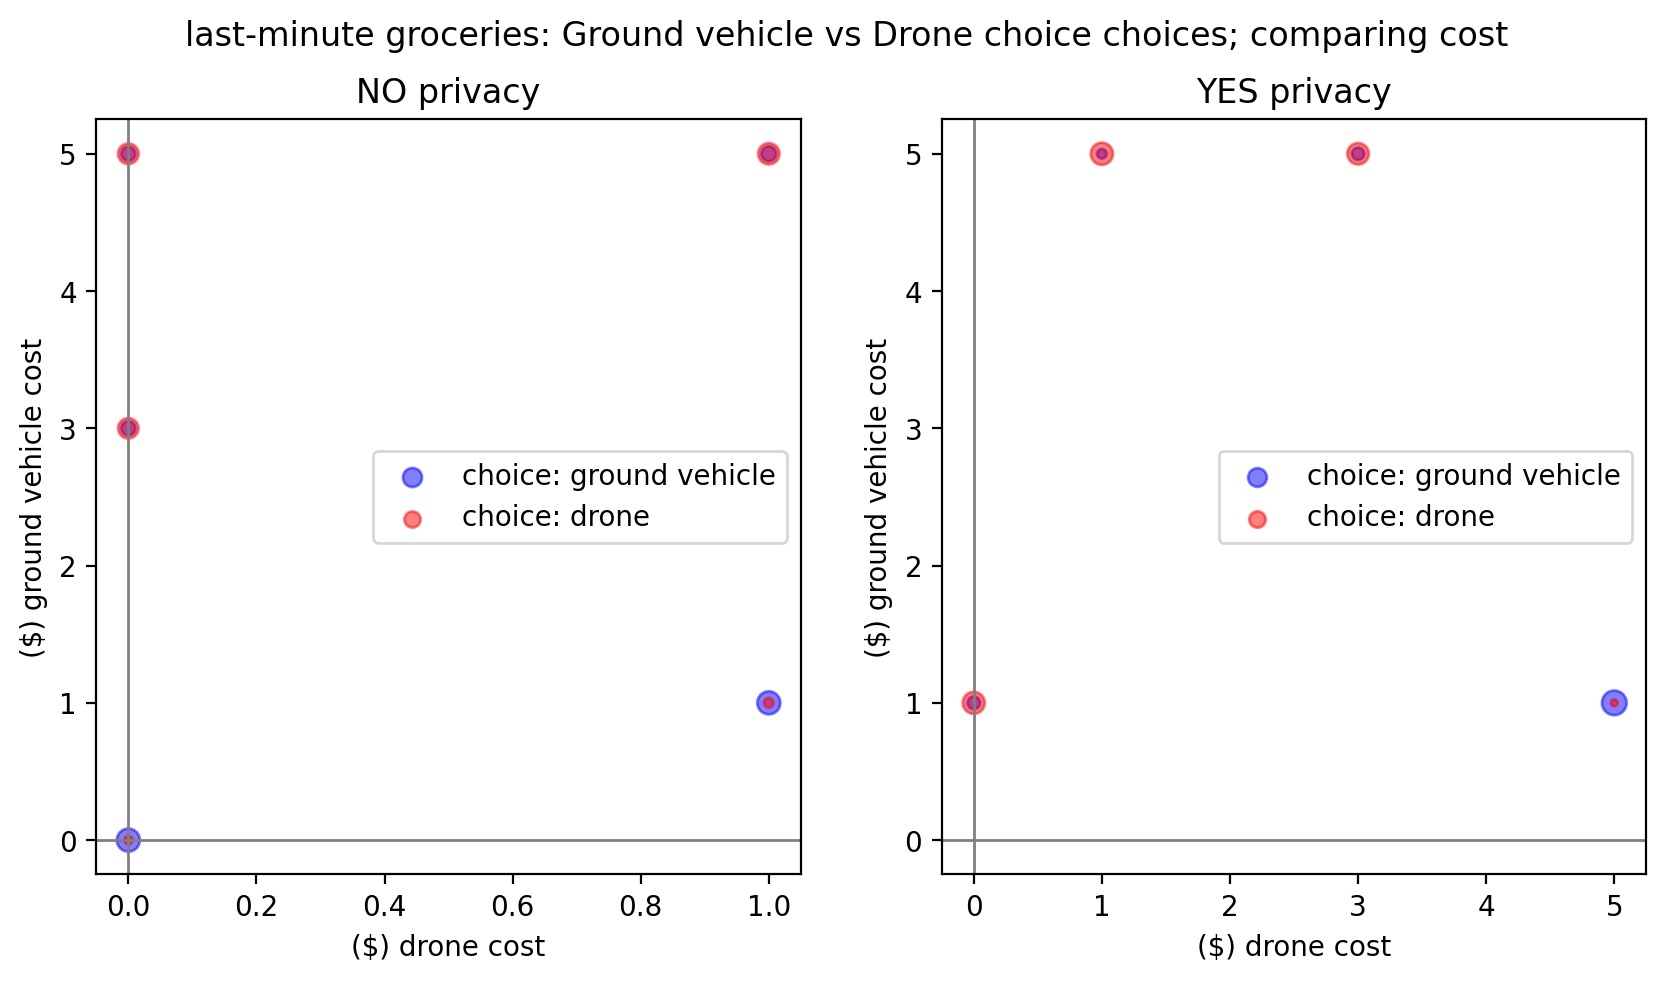

In [11]:
print('limited to choices where drone time = ground vehicle time = 30mins')
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_t30_df[choices_t30_df['v']==v]
    plot_points_cost(vdf, vendor_type[0])

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


In [12]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [13]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    'g_free',
    'd_free',
    #'g_time',     # ground vehicle delivery wait time
    #'d_time',     # drone delivery wait time
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
     
    # dummy code vendor type
    'takeout_food', 'medications', 'liquor_store', 'groceries',
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'age_young',
    'age_old',
    'residence_house',
    'residence_apartment',
    'urban',
    'suburban',
    'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
    
]

In [14]:
def get_vendor_panel_database(name='v-all', t30=False):
    """Returns new fresh database each time."""
    db_name = name
    cdf = choices_t30_df if t30 else choices_no_t_df
    df = cdf[model_choice_cols].copy()
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [15]:
database = get_vendor_panel_database()
database.data.head()

,ID,choice,g_cost,d_cost,g_free,d_free,d_privacy,takeout_food,medications,liquor_store,...,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,_biogroups
0,0,1,3,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,0,1,1
1,0,1,5,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,0,1,1
2,0,0,0,1,1,0,1,0,1,0,...,1,0,0,1,1,0,0,0,1,1
3,0,1,1,0,0,1,0,1,0,0,...,1,0,0,1,1,0,0,0,1,1
4,0,1,5,1,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,1,1


In [16]:
# To use the names of variables as Python variables.
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. 
# Use Pandas functions to invesigate the database
database.data.describe()

,ID,choice,g_cost,d_cost,g_free,d_free,d_privacy,takeout_food,medications,liquor_store,...,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,_biogroups
count,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,...,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000
mean,1865.513890,0.391073,2.874567,2.684725,0.184148,0.258792,0.491189,0.301116,0.328665,0.183763,...,0.495960,0.132128,0.705040,0.269104,0.282262,0.553674,0.159215,0.207772,0.068642,1788.104810
std,1072.904018,0.488010,2.760982,2.864162,0.387620,0.437988,0.499942,0.458761,0.469746,0.387306,...,0.500003,0.338643,0.456042,0.443511,0.450118,0.497130,0.365891,0.405728,0.252854,1028.273896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,940.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,896.000000
50%,1862.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1786.000000
75%,2796.500000,1.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2679.500000
max,3714.000000,1.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3560.000000


In [17]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

# order how parameters are printed in this way; 
# accounting for when parameters are alternative specific or not, or included or not
param_order = [
    'ASC_D_MEAN', 'ASC_D_S', 
    'B_COST_MEAN', 'B_COST_S', 
    'B_G_COST_MEAN', 'B_G_COST_S', 'B_D_COST_MEAN', 'B_D_COST_S',
    'B_FREE',
    
    'B_TAKEOUT_FOOD',
    'B_MEDICATIONS',
    'B_LIQUOR_STORE',  
    'B_GROCERIES', 
    'B_TAKEOUT_FOOD_PRIVACY',
    'B_MEDICATIONS_PRIVACY',
    'B_LIQUOR_STORE_PRIVACY',
    'B_GROCERIES_PRIVACY', 
    
    'B_FREQ_ECOMMERCE', 'B_FREQ_ECOMMERCE_PRIVACY', 
    'B_FREQ_TAKEOUT_FOOD', 'B_FREQ_TAKEOUT_FOOD_PRIVACY', 
    
    'B_MALE', 'B_MALE_PRIVACY',
    'B_AGE_OLD', 'B_AGE_OLD_PRIVACY',
    'B_AGE_YOUNG', 'B_AGE_YOUNG_PRIVACY',
    'B_RESIDENCE_APARTMENT', 'B_RESIDENCE_APARTMENT_PRIVACY',
    'B_RESIDENCE_HOUSE', 'B_RESIDENCE_HOUSE_PRIVACY', 
    'B_RURAL', 'B_RURAL_PRIVACY', 
    'B_SUBURBAN', 'B_SUBURBAN_PRIVACY', 
    'B_URBAN', 'B_URBAN_PRIVACY',
]

def print_biogeme_results(results):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    params = results.getEstimatedParameters()[['Value', 'Std err', 'p-value']].round(4)
    params[''] = params['p-value'].apply(lambda p: '**' if p<0.01 else ('*' if p<0.05 else ''))
    params = params.reindex([p for p in param_order if p in params.index])
    display(params)
    print('\n---- Model statistics ----\n')
    print('sample size: N=%s' % results.data.sampleSize)
    print('observations: n=%s' % results.data.numberOfObservations)
    print('no. of parameters: K=%s' % results.data.nparam)
    print('log likelihood: LL=%s' % results.data.logLike)
    print('adjusted likelihood ratio index: rho-bar-squared:=%s' % results.data.rhoBarSquare)
    

### RPLM

start with:
- parameters that were consistently important in models for individual vendors
    - ASC variance specification
    - free
- experimental:
    - random cost parameter

- include vendor type in specification

then check:
- alternative specific cost

test adding consumer behavior variables

test adding demographic variables

#### drone time = ground vehicle time

Alternative specific constants with variance 

We fix ground vehicle as the ASC normalized to 0.

In [25]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database()
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0 as the reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')
# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=100
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'RPLM.'
    )
)
biogeme.modelName = 'v_all_RPLM'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(rplm_results)

100 draws
start time: 22:20:13
[22:20:13] < Warning >   Cannot read file __v3_RPLM.iter. Statement is ignored.
end time: 22:22:06
Model: v3_RPLM

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.5815,0.1375,0.0000,**
ASC_D_S,2.4165,0.1020,0.0000,**
B_COST_MEAN,-1.1425,0.0479,0.0000,**
B_COST_S,0.8454,0.0458,0.0000,**
B_FREE,0.8001,0.0839,0.0000,**
B_TAKEOUT_FOOD_PRIVACY,2.3465,0.1562,0.0000,**
B_GROCERIES,-0.1632,0.1587,0.3037,
B_GROCERIES_PRIVACY,2.7460,0.1961,0.0000,**
B_LIQUOR_STORE,-0.2403,0.1664,0.1487,
B_LIQUOR_STORE_PRIVACY,2.6401,0.1939,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=12
log likelihood: LL=-5353.599909689566
adjusted likelihood ratio index: rho-bar-squared:=0.35610238902131863


#### Results overview


In [29]:
betas = rplm_results.getBetaValues()

print('how to evaluate value of privacy?')
vop = betas['B_TAKEOUT_FOOD_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for take-out food: %0.2f' % vop)
vop = betas['B_MEDICATIONS_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for prescription medications: %0.2f' % vop)
vop = betas['B_LIQUOR_STORE_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for liquor store: %0.2f' % vop)
vop = betas['B_GROCERIES_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for groceries: %0.2f' % vop)
# B_PRIVACY/B_COST

how to evaluate value of privacy?
value of privacy ($) for take-out food: -2.05
value of privacy ($) for prescription medications: -3.39
value of privacy ($) for liquor store: -2.31
value of privacy ($) for groceries: -2.40


Unrestricted model version

where cost is alternative specific

In [30]:
"""
Using takeout_food as the reference level for vendor type (fixed to 0)

V_groundvehicle = B_g_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database()
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on other models
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_G_COST_MEAN = Beta('B_G_COST_MEAN', 0, None, None, 0)
B_G_COST_S = Beta('B_G_COST_S', 1, None, None, 0)
B_G_COST = B_G_COST_MEAN + B_G_COST_S * bioDraws('B_G_COST', 'NORMAL_ANTI')

B_D_COST_MEAN = Beta('B_D_COST_MEAN', 0, None, None, 0)
B_D_COST_S = Beta('B_D_COST_S', 1, None, None, 0)
B_D_COST = B_D_COST_MEAN + B_D_COST_S * bioDraws('B_D_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_G_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Alternative specific estimation of RPLM.'
    )
)
biogeme.modelName = 'v_all_as_cost_RPLM_1'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
as_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(as_rplm_results)

200 draws
start time: 22:26:15
[22:26:15] < Warning >   Cannot read file __v3_as_cost_RPLM_1.iter. Statement is ignored.
end time: 22:32:35
Model: v3_as_cost_RPLM_1

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.0602,0.1268,0.0000,**
ASC_D_S,1.7199,0.0992,0.0000,**
B_G_COST_MEAN,-0.8964,0.0387,0.0000,**
B_G_COST_S,0.6670,0.0382,0.0000,**
B_D_COST_MEAN,-0.9644,0.0472,0.0000,**
B_D_COST_S,0.4251,0.0356,0.0000,**
B_FREE,0.6235,0.0796,0.0000,**
B_MEDICATIONS,-1.5708,0.1890,0.0000,**
B_LIQUOR_STORE,-0.4023,0.1582,0.0110,*
B_GROCERIES,-0.2881,0.1467,0.0495,*



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=14
log likelihood: LL=-5500.528935052684
adjusted likelihood ratio index: rho-bar-squared:=0.3559215637710925


#### Results overview

rho-bar-squared decreased when alternative specific cost was added -- does not support alternative specific cost.

We do not use alternative specific cost in these models.


### Consumer behavior attributes and interactions with privacy parameter

We add in the following parameters. Positively estimated coefficients will indicate a positive relationship between these parameters and drone preference.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week
    - included in first iteration of model estimation --> largest p-values; removed.

In [33]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database()
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
# B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
# B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy


# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Estimation of RPLM with consumer behavior variables.'
    )
)
biogeme.modelName = 'v_all_RPLM_consumer'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(cons_rplm_results)

200 draws
start time: 22:52:45
[22:52:45] < Warning >   Cannot read file __v_all_RPLM_consumer.iter. Statement is ignored.
end time: 22:57:36
Model: v_all_RPLM_consumer

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.6545,0.1448,0.0000,**
ASC_D_S,2.4232,0.1026,0.0000,**
B_COST_MEAN,-1.1548,0.0484,0.0000,**
B_COST_S,-0.8419,0.0447,0.0000,**
B_FREE,0.8272,0.0844,0.0000,**
B_MEDICATIONS,-1.6547,0.1937,0.0000,**
B_LIQUOR_STORE,-0.2604,0.1668,0.1186,
B_GROCERIES,-0.2179,0.1596,0.1722,
B_TAKEOUT_FOOD_PRIVACY,2.3877,0.1629,0.0000,**
B_MEDICATIONS_PRIVACY,4.0213,0.2151,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=14
log likelihood: LL=-5342.491493877714
adjusted likelihood ratio index: rho-bar-squared:=0.35711771124797753


#### Results overview

- Frequent e-commerce behavior is statistically signigicant. 
- Fequent take-out food and (Frequent e-commerce x privacy) are not. 

For next models: keep frequent e-commerce but no privacy x e-commerce interaction effect


In [35]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database()
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
# B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
# B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
# B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce


# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Estimation of RPLM with freq e-commerce.'
    )
)
biogeme.modelName = 'v_all_RPLM_consumer_2'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_rplm_results_2 = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(cons_rplm_results_2)

200 draws
start time: 23:05:21
[23:05:21] < Warning >   Cannot read file __v_all_RPLM_consumer_2.iter. Statement is ignored.
end time: 23:09:47
Model: v_all_RPLM_consumer_2

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.6130,0.1418,0.0000,**
ASC_D_S,2.4206,0.1025,0.0000,**
B_COST_MEAN,-1.1529,0.0483,0.0000,**
B_COST_S,-0.8403,0.0447,0.0000,**
B_FREE,0.8279,0.0844,0.0000,**
B_MEDICATIONS,-1.6567,0.1935,0.0000,**
B_LIQUOR_STORE,-0.2611,0.1667,0.1171,
B_GROCERIES,-0.2112,0.1594,0.1854,
B_TAKEOUT_FOOD_PRIVACY,2.3154,0.1556,0.0000,**
B_MEDICATIONS_PRIVACY,3.9551,0.2099,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=13
log likelihood: LL=-5343.764634428884
adjusted likelihood ratio index: rho-bar-squared:=0.3570849291138346


#### Results overview

Frequent ecommerce use is no longer statistically significant without the interaction effect with privacy.

For now, we keep it.

Overall, the consumer behavior model only added 1 additional variable.

We take the above model and add demographic variables.

### Demographic variables and interactions with privacy parameter

We add in the following parameters which we assume are generic across drone and ground vehicle delivery.

- gender: male/non-male (1/0)
- age: age_young, age_old (0/1)
- residential type: residence_house, residence_apartment (0/1)
    - only include residence_house
- residential area: urban, suburban, rural (0/1)
    - only include urban, suburban

In [38]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_male * male
    + B_age_young * age_young + B_age_old * age_old
    + B_residence_house * residence_house
    + B_urban * urban 
    + B_suburban * suburban
    + [demographics] * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database()
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant
B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0) # << the only statistically significant variable

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_RESIDENCE_HOUSE = Beta('B_RESIDENCE_HOUSE', 0, None, None, 0)
# B_RESIDENCE_APARTMENT = Beta('B_RESIDENCE_APARTMENT', 0, None, None, 0)
B_RESIDENCE_HOUSE_PRIVACY = Beta('B_RESIDENCE_HOUSE_PRIVACY', 0, None, None, 0)
# B_RESIDENCE_APARTMENT_PRIVACY = Beta('B_RESIDENCE_APARTMENT_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
# B_RURAL = Beta('B_RURAL', 0, None, None, 0)
B_URBAN_PRIVACY = Beta('B_URBAN_PRIVACY', 0, None, None, 0)
B_SUBURBAN_PRIVACY = Beta('B_SUBURBAN_PRIVACY', 0, None, None, 0)
# B_RURAL_PRIVACY = Beta('B_RURAL_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy


# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Estimation of RPLM with demographics.'
    )
)
biogeme.modelName = 'v_all_RPLM_demos'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demos_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(demos_rplm_results)

200 draws
start time: 23:10:23
[23:10:23] < Warning >   Cannot read file __v_all_RPLM_demos.iter. Statement is ignored.
end time: 23:24:34
Model: v_all_RPLM_demos

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.8566,0.2977,0.0000,**
ASC_D_S,2.3812,0.1024,0.0000,**
B_COST_MEAN,-1.1536,0.0482,0.0000,**
B_COST_S,-0.8365,0.0445,0.0000,**
B_FREE,0.8394,0.0848,0.0000,**
B_MEDICATIONS,-1.6461,0.1945,0.0000,**
B_LIQUOR_STORE,-0.2526,0.1668,0.1300,
B_GROCERIES,-0.1821,0.1598,0.2545,
B_TAKEOUT_FOOD_PRIVACY,2.4405,0.3325,0.0000,**
B_MEDICATIONS_PRIVACY,4.0785,0.3561,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=25
log likelihood: LL=-5285.937179611805
adjusted likelihood ratio index: rho-bar-squared:=0.36258510755604023


#### Results overview

Urban is the only residence related parameter that has statistical significance.

We keep urban and suburban in the next model iteration.

We remove all other residence related parameters and their interactions with privacy.

In [40]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_male * male
    + B_age_young * age_young + B_age_old * age_old
    + B_urban * urban 
    + B_suburban * suburban
    + [demographics] * privacy ... for some

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database()
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant
B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0) # << the only statistically significant variable

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
# B_RURAL = Beta('B_RURAL', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_URBAN*urban \
    + B_SUBURBAN*suburban


# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Estimation of RPLM with demographics round 2.'
    )
)
biogeme.modelName = 'v_all_RPLM_demos_2'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demos_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(demos_rplm_results)

200 draws
start time: 11:56:36
[11:56:36] < Warning >   Cannot read file __v_all_RPLM_demos_2.iter. Statement is ignored.
end time: 12:15:10
Model: v_all_RPLM_demos_2

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.8540,0.2328,0.0000,**
ASC_D_S,2.3804,0.1023,0.0000,**
B_COST_MEAN,-1.1533,0.0481,0.0000,**
B_COST_S,-0.8362,0.0445,0.0000,**
B_FREE,0.8391,0.0847,0.0000,**
B_MEDICATIONS,-1.6428,0.1942,0.0000,**
B_LIQUOR_STORE,-0.2530,0.1667,0.1291,
B_GROCERIES,-0.1817,0.1597,0.2554,
B_TAKEOUT_FOOD_PRIVACY,2.3493,0.2125,0.0000,**
B_MEDICATIONS_PRIVACY,3.9855,0.2567,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=21
log likelihood: LL=-5286.530067831734
adjusted likelihood ratio index: rho-bar-squared:=0.36299402668187275


### Estimating a final model

After reviewing the significant coefficients from the models estimated for each vendor type, we choose a model specification that uses consistent consumer group variables across the models. 

These variables are chosen to represent variables that were statistically significant in models for at least one vendor.


Frequent e-commerce use
- alone statistically significant in models for multiple vendors
- interaction effect x privacy significant in at least one model (v2)

Residential area
- urban statistically significant in multiple models
- interaction effect x privacy NOT significant in any model - not included

In [20]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_male * male
    + B_age_young * age_young + B_age_old * age_old
    + B_urban * urban 
    + B_suburban * suburban
    + [age demographics] * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
database = get_vendor_panel_database()
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2.5, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 2, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant
B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
# B_RURAL = Beta('B_RURAL', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_URBAN*urban \
    + B_SUBURBAN*suburban


# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws=5000
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    seed=12, # consistnet random seed for consistent results
    userNotes=(
        'Final estimation of RPLM with demographics.'
    )
)
biogeme.modelName = 'v_all_RPLM_final'

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
final_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(final_rplm_results)

5000 draws
start time: 20:54:00
[20:54:00] < Warning >   Cannot read file __v_all_RPLM_final.iter. Statement is ignored.
end time: 07:12:20
Model: v_all_RPLM_final

---- Coefficients ----


,Value,Std err,p-value,
ASC_D_MEAN,-2.9933,0.2412,0.0000,**
ASC_D_S,2.4186,0.1051,0.0000,**
B_COST_MEAN,-1.1900,0.0507,0.0000,**
B_COST_S,0.8670,0.0462,0.0000,**
B_FREE,0.8216,0.0856,0.0000,**
B_MEDICATIONS,-1.6390,0.1978,0.0000,**
B_LIQUOR_STORE,-0.2439,0.1694,0.1499,
B_GROCERIES,-0.1869,0.1623,0.2497,
B_TAKEOUT_FOOD_PRIVACY,2.4733,0.2243,0.0000,**
B_MEDICATIONS_PRIVACY,4.0943,0.2673,0.0000,**



---- Model statistics ----

sample size: N=3560
observations: n=12995
no. of parameters: K=22
log likelihood: LL=-5267.78263126413
adjusted likelihood ratio index: rho-bar-squared:=0.3088010245727394


#### Results overview

vendor type
- only medications has a statistically significant coefficient. groceries and liquor store do not.
- medications coefficient indicates negative preference for drones vs other vendor types

    
- value of privacy in order of
    - medications
    - groceries
    - liquor store (nearly equal to groceries)
    - take-out food


gender
- Males prefer drones more than non-males
- Males value privacy less than non-males

age
- younger ppl have greater value on privacy than overall population
- other age related coefficients not statistically significant

frequent ecommerce shoppers have slightly greater preference for drone

residence
- urban and suburban residents have slightly less preference for drone
- other residence area and type coefficients not statistically significant

#### Results overview

In [21]:
betas = final_rplm_results.getBetaValues()

print('how to evaluate value of privacy?')
vop = -1*betas['B_TAKEOUT_FOOD_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for take-out food: %0.2f' % vop)
vop = -1*betas['B_MEDICATIONS_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for prescription medications: %0.2f' % vop)
vop = -1*betas['B_LIQUOR_STORE_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for liquor store: %0.2f' % vop)
vop = -1*betas['B_GROCERIES_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for groceries: %0.2f' % vop)
# B_PRIVACY/B_COST

how to evaluate value of privacy?
value of privacy ($) for take-out food: 2.08
value of privacy ($) for prescription medications: 3.44
value of privacy ($) for liquor store: 2.30
value of privacy ($) for groceries: 2.47
